__Importing Libraries__

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, roc_curve, auc
from sklearn import model_selection
from sklearn.base import TransformerMixin
from sklearn.model_selection import KFold
import matplotlib.pylab as plt
import matplotlib.patches as patches
from numpy import interp
from joblib import dump
import os
import joblib
import timeit
from datetime import datetime

cwd = os.getcwd()
print(cwd)

C:\Users\Bala\Documents\CMI\Courses\1-2\DMML\Assignments\A2


In [22]:
DT = 'DT'
DT_long = 'Decision Tree'
GNB = 'GNB'
GNB_long = 'Naive Bayes'
SVM = 'SVM'
SVM_long = 'Support Vector Machine'

### Data Preprocessing

In [23]:
# Replacing the 'unknown' values wit the most frequent values
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

# Function to separate the object and non-object data and Impute the 'unknown' values
def preprocess(df):
    df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']] = df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']].replace('unknown', np.NaN)
    bank_object_data = df.select_dtypes(include="object")
    bank_non_object_data = df.select_dtypes(exclude="object")
    bank_object_data = DataFrameImputer().fit_transform(bank_object_data)
    label = LabelEncoder()
    bank_object_data = bank_object_data.apply(label.fit_transform)
    bank_final = pd.concat([bank_object_data, bank_non_object_data], axis = 1)
    return(bank_final)

In [25]:
df = pd.read_csv('bank-data/bank-additional-full.csv', sep = ';')
bank_final = preprocess(df)

## Function to output k-fold estimates of accuracy, recall, precision, f1, and roc_auc 

In [26]:
def kfold_output(model, X, Y): #function for kfold output
    start = timeit.default_timer()
    begin = datetime.now()
    scoring = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']

    kfold = KFold(n_splits=10, random_state=100, shuffle = True)
    results_kfold = model_selection.cross_validate(model, X, Y, scoring=scoring, cv=kfold)
    print("Recall: %0.2f (+/- %0.2f)" % (results_kfold['test_recall'].mean(), results_kfold['test_recall'].std()))
    print("Precision: %0.2f (+/- %0.2f)" % (results_kfold['test_precision'].mean(), results_kfold['test_precision'].std()))
    print("F1 Score: %0.2f (+/- %0.2f)" % (results_kfold['test_f1'].mean(), results_kfold['test_f1'].std()))
    print("Accuracy: %0.2f (+/- %0.2f)" % (results_kfold['test_accuracy'].mean(), results_kfold['test_accuracy'].std()))
    print("ROC_AUC: %0.2f (+/- %0.2f)" % (results_kfold['test_roc_auc'].mean(), results_kfold['test_roc_auc'].std()))
    
    print(results_kfold)
    
    stop = timeit.default_timer()
    end = datetime.now()
    print('Start Time: ', begin,
          'Stop Time: ', end,
          'Time Taken: ', stop - start)

## Function to print roc curves for k-fold validation sets alongwith their AUC

In [27]:
def classifier_roc(classifier, X_train_res, y_train_res):
    start = timeit.default_timer()
    begin = datetime.now()
    cv = KFold(n_splits=10, random_state=100, shuffle = True)
    cv_split_filenames = []

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=(10,10))
    i = 1
    file_name = ''
    if type(classifier) == type(DecisionTreeClassifier()):
        file_name = DT
        plot_title = DT_long
    elif type(classifier) == type(GaussianNB()):
        file_name = GNB
        plot_title = GNB_long
    else:
        file_name = SVM
        plot_title = SVM_long
    
    if not os.path.exists(plot_title):
        os.mkdir(cwd+"/"+plot_title)
    
    for train, test in cv.split(X_train_res, y_train_res):
        probas_ = classifier.fit(X_train_res.iloc[train], y_train_res.iloc[train]).predict_proba(X_train_res.iloc[test])
        
        cv_split_filenames = cwd+"/"+plot_title + "/" + file_name + str(i)
        dump(probas_,cv_split_filenames)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train_res[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
                        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', 
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Cross-Validation ROC of ' + plot_title,fontsize=14)
    plt.legend(loc="lower right", prop={'size': 10})
    plt.show()
    stop = timeit.default_timer()
    end = datetime.now()
    print('Start Time: ', begin,
      'Stop Time: ', end,
      'Time Taken: ', stop - start)

## Function to plot roc curves using saved parameters

In [28]:
def plot_saved(directory,file_name, X_train_res,y_train_res):
    start = timeit.default_timer()
    begin = datetime.now()
    cv = KFold(n_splits=10, random_state=100, shuffle = True)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=(10,10))
    i = 1
    for train, test in cv.split(X_train_res, y_train_res):
        probas_ = joblib.load(cwd +"/" + directory + "/" + file_name + str(i),mmap_mode = 'c')
         # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train_res[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)     
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Cross-Validation ROC of '+ directory,fontsize=14)
    plt.legend(loc="lower right", prop={'size': 10})
    plt.show()
    stop = timeit.default_timer()
    end = datetime.now()
    print('Start Time: ', begin,
      'Stop Time: ', end,
      'Time Taken: ', stop - start)

## Building dataset for training

In [29]:
X_train_res = bank_final.drop(['y'], axis = 1)
y_train_res = bank_final['y']

## K-fold ouputs and ROC curve for Decision Tree classifier 

In [30]:
dt_classifier = DecisionTreeClassifier(min_samples_split=60, min_samples_leaf=60, class_weight = 'balanced', random_state=20)
kfold_output(dt_classifier,X_train_res,y_train_res)

Recall: 0.92 (+/- 0.01)
Precision: 0.42 (+/- 0.01)
F1 Score: 0.57 (+/- 0.01)
Accuracy: 0.85 (+/- 0.00)
ROC_AUC: 0.94 (+/- 0.00)
{'fit_time': array([0.55163407, 0.12464523, 0.12220049, 0.14480686, 0.13241053,
       0.11774325, 0.11075592, 0.20294642, 0.14512467, 0.13064814]), 'score_time': array([0.10095286, 0.01137328, 0.0118947 , 0.0128417 , 0.01415253,
       0.01020384, 0.00903416, 0.00807571, 0.01154327, 0.01055884]), 'test_accuracy': array([0.84729303, 0.85311969, 0.84340859, 0.84972081, 0.83636805,
       0.84680748, 0.84777859, 0.84098082, 0.84944148, 0.84725595]), 'test_recall': array([0.91397849, 0.89497717, 0.93528184, 0.90356394, 0.93075356,
       0.91823899, 0.92144374, 0.93023256, 0.89498807, 0.92222222]), 'test_precision': array([0.41913215, 0.41219769, 0.42184557, 0.42928287, 0.4165907 ,
       0.42524272, 0.42382812, 0.41431262, 0.39432177, 0.41129832]), 'test_f1': array([0.57471264, 0.56443485, 0.58144062, 0.58203916, 0.57556675,
       0.58128733, 0.58060201, 0.5732

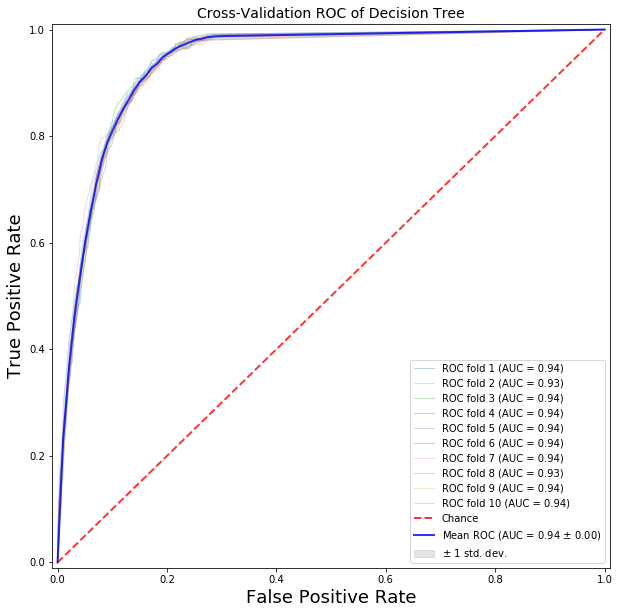

Start Time:  2020-04-26 15:41:14.995046 Stop Time:  2020-04-26 15:41:16.751722 Time Taken:  1.7568243999999993


In [11]:
classifier_roc(dt_classifier, X_train_res, y_train_res)

## ROC curve for Decision Tree classifier using saved parameters

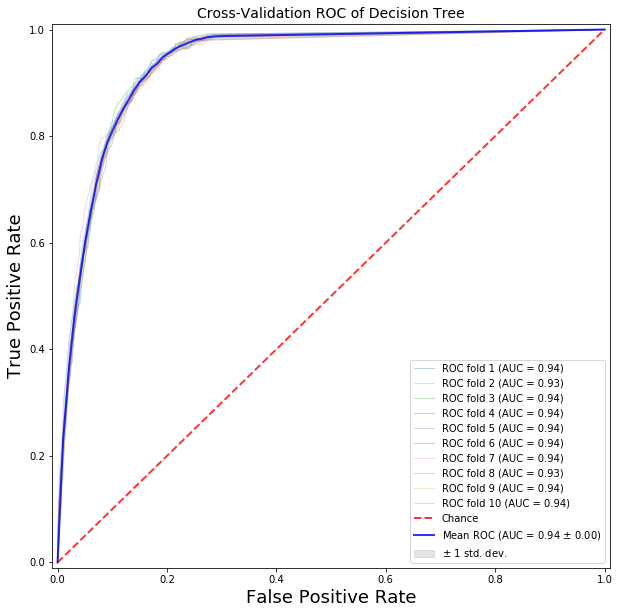

Start Time:  2020-04-26 15:41:19.704434 Stop Time:  2020-04-26 15:41:20.005628 Time Taken:  0.3012359000000018


In [12]:
plot_saved(DT_long, DT, X_train_res,y_train_res)

## K-fold ouputs and ROC curve for Naive bayes classifier 

In [20]:
nb_classifier = GaussianNB(priors = [0.11, 0.89])
kfold_output(nb_classifier,X_train_res,y_train_res)

Recall: 0.83 (+/- 0.02)
Precision: 0.26 (+/- 0.01)
F1 Score: 0.40 (+/- 0.02)
Accuracy: 0.72 (+/- 0.01)
ROC_AUC: 0.86 (+/- 0.01)
{'fit_time': array([0.03595591, 0.02892351, 0.03590584, 0.02889013, 0.02988458,
       0.03091645, 0.02692842, 0.02892184, 0.02692819, 0.02692866]), 'score_time': array([0.01494098, 0.01296425, 0.01798654, 0.01196647, 0.01396418,
       0.01196861, 0.01296496, 0.01196814, 0.01097107, 0.01499963]), 'test_accuracy': array([0.70648216, 0.72371935, 0.72177713, 0.72881767, 0.71279437,
       0.7157077 , 0.7038116 , 0.72226269, 0.71345313, 0.73288004]), 'test_recall': array([0.8       , 0.81050228, 0.84968685, 0.83438155, 0.82688391,
       0.83438155, 0.80254777, 0.8435518 , 0.82338902, 0.84222222]), 'test_precision': array([0.25      , 0.25177305, 0.27481431, 0.27715877, 0.26994681,
       0.26711409, 0.25116279, 0.27161334, 0.23776706, 0.26917614]), 'test_f1': array([0.38095238, 0.38419913, 0.41530612, 0.41610037, 0.40701754,
       0.40467717, 0.38259109, 0.4109

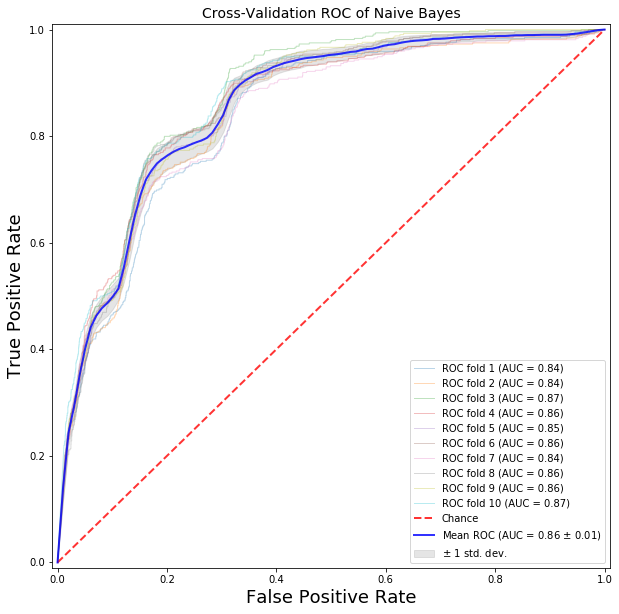

Start Time:  2020-04-26 15:41:25.265394 Stop Time:  2020-04-26 15:41:25.929671 Time Taken:  0.6642879999999991


In [14]:
classifier_roc(nb_classifier, X_train_res, y_train_res)

## ROC curve for Naive Bayes classifier using saved parameters

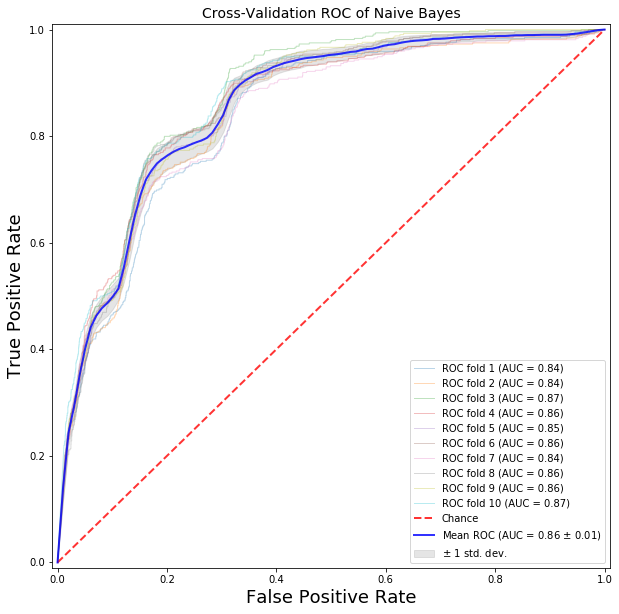

Start Time:  2020-04-26 15:41:29.202751 Stop Time:  2020-04-26 15:41:29.562335 Time Taken:  0.3591756000000004


In [15]:
plot_saved(GNB_long, GNB, X_train_res,y_train_res)

## K-fold ouputs and ROC curve for SVM with plynomial kernel

In [16]:
svm_classifier = SVC(kernel = 'poly', random_state = 0, class_weight = 'balanced')
kfold_output(svm_classifier,X_train_res,y_train_res)

Recall: 0.86 (+/- 0.02)
Precision: 0.40 (+/- 0.01)
F1 Score: 0.54 (+/- 0.01)
Accuracy: 0.84 (+/- 0.00)
ROC_AUC: 0.92 (+/- 0.00)
{'fit_time': array([30.32745337, 30.33124638, 31.4992497 , 30.54082561, 30.9915328 ,
       35.33771086, 34.59846258, 33.66181946, 31.86866832, 35.12172508]), 'score_time': array([2.820364  , 2.73974872, 2.90521097, 2.79356456, 3.08678079,
       3.08637118, 3.34132648, 3.44902897, 2.48543358, 2.93081903]), 'test_accuracy': array([0.83466861, 0.8443797 , 0.84413693, 0.84170915, 0.83224084,
       0.83563972, 0.83224084, 0.83661083, 0.83827101, 0.83802817]), 'test_recall': array([0.84946237, 0.85159817, 0.88517745, 0.83018868, 0.87169043,
       0.83857442, 0.86836518, 0.86680761, 0.849642  , 0.87111111]), 'test_precision': array([0.39264414, 0.39304531, 0.41938675, 0.40951396, 0.40530303,
       0.4       , 0.39402697, 0.40196078, 0.37122002, 0.39160839]), 'test_f1': array([0.53704963, 0.53785148, 0.56912752, 0.54847645, 0.55332902,
       0.54163846, 0.542080

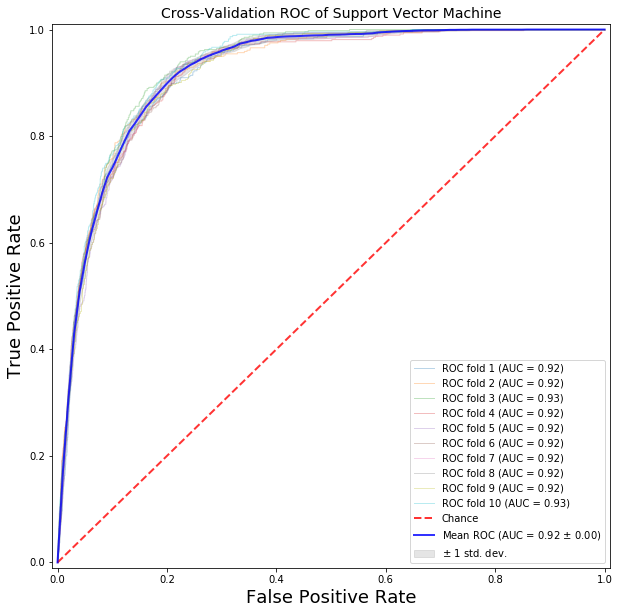

Start Time:  2020-04-26 15:47:43.932066 Stop Time:  2020-04-26 16:20:11.413409 Time Taken:  1947.4813641000003


In [17]:
roc_svm_classifier = SVC(kernel = 'poly', probability = True, random_state = 0, class_weight = 'balanced')
classifier_roc(roc_svm_classifier, X_train_res, y_train_res)

## ROC curve for SVM classifier using saved parameters

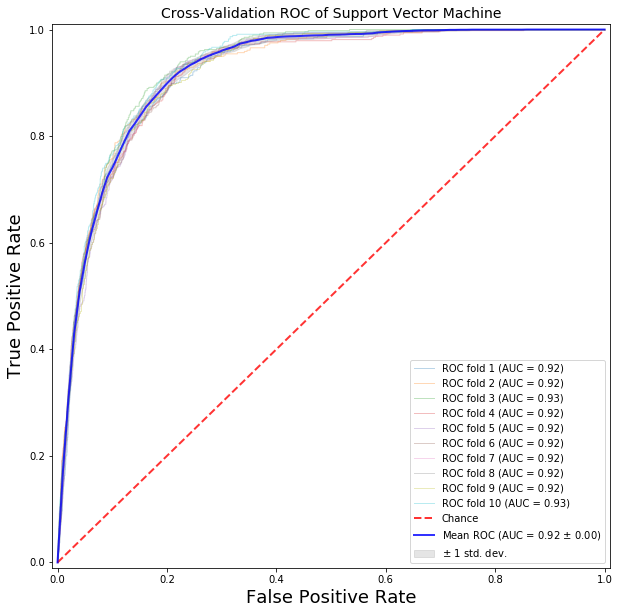

Start Time:  2020-04-26 17:59:01.445084 Stop Time:  2020-04-26 17:59:01.756486 Time Taken:  0.31091109999943


In [18]:
plot_saved(SVM_long, SVM, X_train_res,y_train_res)

__Among the models we observed that:__ 
__SVM with 'poly' kernal and 'balanced' class_weights gave:__ 
    #Recall: 0.86 (+/- 0.02); Precision: 0.40 (+/- 0.01);
    #F1 Score: 0.54 (+/- 0.01); Accuracy: 0.84 (+/- 0.00); ROC_AUC: 0.92 (+/- 0.00)

__Gaussian Naive Bayes with priors priors = [0.11, 0.89] gave:__
    #Recall: 0.83 (+/- 0.02); Precision: 0.26 (+/- 0.01)
    #F1 Score: 0.40 (+/- 0.02); Accuracy: 0.72 (+/- 0.01); ROC_AUC: 0.86 (+/- 0.01)

__The decision tree classifier with min_samples_split=60, min_samples_leaf=60, 
class_weight = 'balanced' gave:__
    #Recall: 0.92 (+/- 0.01); Precision: 0.42 (+/- 0.01); F1 Score: 0.57 (+/- 0.01)
    #Accuracy: 0.85 (+/- 0.00); ROC_AUC: 0.94 (+/- 0.00)

__Among the models the decision tree gave the best results as it had te highest recall, F1-score and
ROC_AUC but SVM was a close second to decision tree.__